El pozo 160699 ya existe en la DB
El pozo 158790 ya existe en la DB
El pozo 161654 ya existe en la DB
El pozo 157110 ya existe en la DB
El pozo 161641 ya existe en la DB


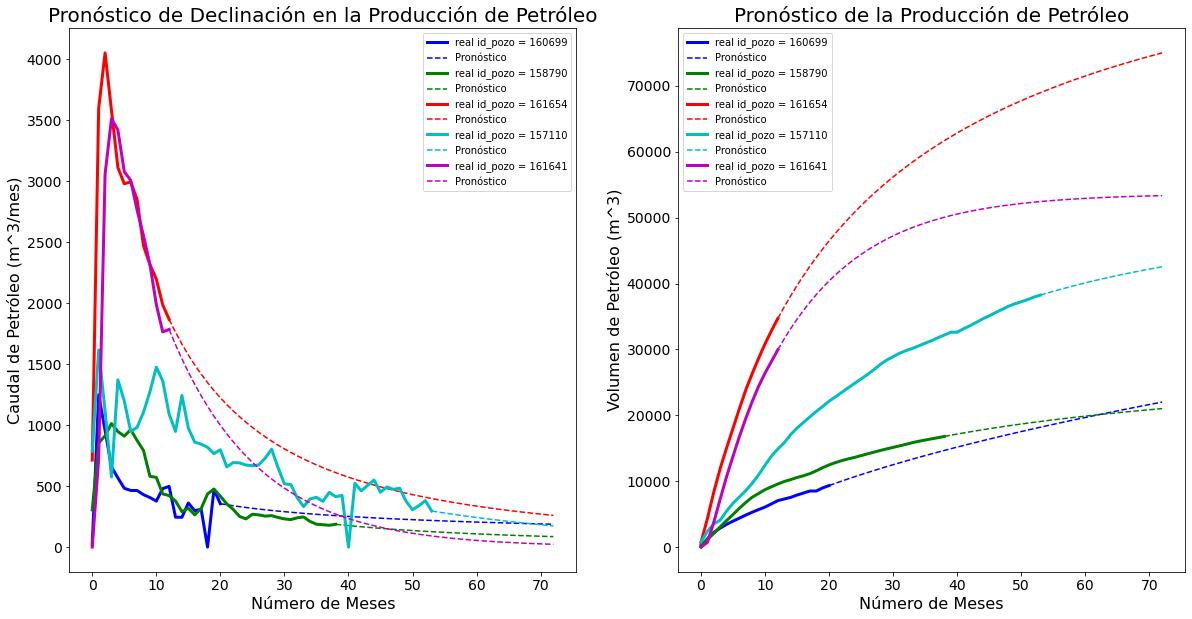

In [1]:
import pyodbc
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import numpy as np

# Set dafault parameters
plt.rcParams['axes.titlesize'] = 20
plt.rcParams["figure.titlesize"] = 19
plt.rcParams['axes.labelsize'] = 16
plt.rcParams["figure.figsize"] = (10,7)
plt.rcParams["xtick.labelsize"] = 14
plt.rcParams["ytick.labelsize"] = 14

def hyperbolic_equation(t, qi, b, di):
    """
    Hyperbolic decline curve equation
    Arguments:
        t: Float. Time since the well first came online, can be in various units 
        (days, months, etc) so long as they are consistent.
        qi: Float. Initial production rate when well first came online.
        b: Float. Hyperbolic decline constant
        di: Float. Nominal decline rate at time t=0
    Output: 
        Returns q, or the expected production rate at time t. Float.
    """
    return qi/((1.0+b*di*t)**(1.0/b))

def get_max_initial_production(months):
    ''' id_pozo(int) = The well you want to get the max initial production
        months(int) = How many month since start production you want to search the max'''
    
    max_initial_production = produccion_pozo.head(months).sort_values(ascending=False)[0]
    return max_initial_production

# Set driver for MS Access and file path
driver = '{Microsoft Access Driver (*.mdb, *.accdb)}'
filepath = r'F:\Downloads\Telegram Desktop\Produccion NOC SEN_Valida.accdb'

# Stablish conection and set cursor
conn = pyodbc.connect(driver=driver,dbq=filepath)
cursor = conn.cursor()

# Query
query = 'SELECT IDPOZO,FECHA,QO_EF FROM POZOS_FORM_PRODUCCION ORDER BY IDPOZO,FECHA'

# Convert the query into df and make change name of columns to lowercase
df = pd.read_sql_query(query, conn)
df.columns = df.columns.str.lower()

# Set fecha as index
df.set_index('fecha',inplace=True)

# Set go_ef_mes and delete qo_ef
df['qo_ef_mes'] = df['qo_ef'] * 30.4167
del df['qo_ef']

# Creating the table in the DB
try:
    cursor.execute('create table prono_andres (id_pozo int, numero_meses int,qo_pronostico float)')
    cursor.commit()
except:
    pass

# Search for maximum amount of months
ids_pozos = [160699,158790,161654,157110,161641]
#ids_pozos= [161641]
mas_largo =[]
for id_pozo in ids_pozos:
    produccion_pozo = df[df['idpozo']==id_pozo]['qo_ef_mes']
    meses_en_produccion= len(produccion_pozo.index)
    mas_largo.append(meses_en_produccion)
mas_largo=max(mas_largo)

fig,ax = plt.subplots(1,2,figsize=(20,10))
ax=ax.ravel()

for n,id_pozo in enumerate(ids_pozos):
    # Production rate Series of the well id_pozo
    produccion_pozo = df[df['idpozo']==id_pozo]['qo_ef_mes']


    # Set the max initial production rate as qi
    qi = get_max_initial_production(6)
    # Search the index where qo = qi(max)
    for index_mes_inicial,qo in enumerate(produccion_pozo):
        if qo == qi:
            break

    # Production rates since qi
    caudales = produccion_pozo[index_mes_inicial:].values
    # Number of months the well produced since qi
    month_since_qi = range(len(produccion_pozo.index) - index_mes_inicial)

    #Hyperbolic curve fit the data to get best fit equation
    popt_hyp, pcov_hyp=curve_fit(hyperbolic_equation, month_since_qi,caudales,bounds=(0, [qi,2,20]))
    #print('Hyperbolic Fit Curve-fitted Variables: qi='+str(popt_hyp[0])+', b='+str(popt_hyp[1])+', di='+str(popt_hyp[2]))

    # Create a list of number of month to forecast
    meses_pronostico = list(range(mas_largo))
    for i in range(meses_pronostico[-1]+1,meses_pronostico[-1]+20,1):
        meses_pronostico.append(i)
    
    # Production rate forecast
    qo_prono = [hyperbolic_equation(mes,qi,popt_hyp[1],popt_hyp[2]) for mes in meses_pronostico]

    # Slices meses_pronostico so it starts from when qi = max production rate happened
    meses_pronostico = meses_pronostico[index_mes_inicial:]

    # Slices qo_prono so it matchs meses_pronostico lenght
    qo_prono = qo_prono[:-index_mes_inicial]
    # Fix qo_prono so it matches last real qo
    last_qo = produccion_pozo[-1]
    last_qo_forecasted = qo_prono[month_since_qi[-1]]
    qo_prono_fix = np.array(qo_prono)*(last_qo / last_qo_forecasted)
    
    
    
    # Plot the Forecast
    colors = ['b','g','r','c','m','k','y']
    # Tiempo que dura la producción real
    meses_qo=range(len(produccion_pozo.index))
    # Produccion real
    qo=produccion_pozo.values
    # Produccion pronosticada
    qo_prono = qo_prono_fix[month_since_qi[-1]:]
    # Tengo que hacer esto por que qo y qo_prono tienen repetidos el ultimo y primer valor respctivamente
    qo_prono = qo_prono[1:]
    # Meses correspondientes al pronostico
    meses_qo_prono = np.array(meses_pronostico[month_since_qi[-1]:])
    # Lo mismo que sucede con qo_prono
    meses_qo_prono = meses_qo_prono[1:]
   
    #Meses totales real  + pronostico
    fecha=np.concatenate((meses_qo,meses_qo_prono))
    #Produccion total real + pronosicada
    produccion = np.concatenate((qo,qo_prono))
    #Parte que corresponde solo a la real
    qo=produccion[:meses_qo[-1]+1]
    #Parte que corresponde solo a la pronosticada
    qo_forecasted=produccion[meses_qo[-1]:]
    #Fecha que corresponde solo a la produccion real del pozo
    fecha_qo =fecha[:meses_qo[-1]+1]
    #Fecha que corresponde  a la produccion pronosticada
    fecha_qo_forecasted = fecha[meses_qo[-1]:]
    #Calculo NP en los meses de produccion real
    np_real = produccion.cumsum()[:meses_qo[-1]+1]
    #Calculo de NP pronosticado
    np_forecasted = produccion.cumsum()[meses_qo[-1]:]
    
    ax[0].plot(fecha_qo,qo,label=f'real id_pozo = {id_pozo}',color=colors[n],linewidth=3)
    ax[0].plot(fecha_qo_forecasted,qo_forecasted,linestyle='--',label='Pronóstico',color=colors[n])
    #plt.plot(meses_pronostico,qo_prono,linestyle='--',label='Pronóstico')
    ax[0].set_xlabel('Número de Meses')
    ax[0].set_ylabel('Caudal de Petróleo (m^3/mes)')
    ax[0].set_title(f'Pronóstico de Declinación en la Producción de Petróleo')
    ax[0].legend()
    
    ax[1].plot(fecha_qo,np_real,label=f'real id_pozo = {id_pozo}',color=colors[n],linewidth=3)
    ax[1].plot(fecha_qo_forecasted,np_forecasted,linestyle='--',label='Pronóstico',color=colors[n])
    #plt.plot(meses_pronostico,qo_prono,linestyle='--',label='Pronóstico')
    ax[1].set_xlabel('Número de Meses')
    ax[1].set_ylabel('Volumen de Petróleo (m^3)')
    ax[1].set_title(f'Pronóstico de la Producción de Petróleo')
    ax[1].legend()
    
    
    
    
    # Writting forecast into data base
    meses_pronostico = list(map(int,meses_pronostico))
    qo_prono = list(map(float,qo_prono))
    id_pozo = list(map(int,[id_pozo]*len(qo_prono)))
    Pronos_DCA = list(zip(id_pozo,meses_pronostico,qo_prono))
    
   
        
    # Insert the data into de table
    query = f'SELECT id_pozo FROM prono_andres WHERE id_pozo = {id_pozo[0]}'
    cursor.execute(query)
    if not cursor.fetchall():
        cursor.executemany("""insert into prono_andres (id_pozo , month_since_qi, qo_pronostico) values(?,?,?)""", Pronos_DCA)
        cursor.commit()
        print(f'El pronóstico del pozo {id_pozo[0]} se ha insertado correctamente')
    else:
        print(f'El pozo {id_pozo[0]} ya existe en la DB')

plt.show()